# Find the central star of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   :May 29th 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [28]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [29]:
print theNotebook

FindCentralStar


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [31]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [32]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [33]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [34]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [35]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [36]:
from IPython.display import Image, display

In [37]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [38]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [39]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [40]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [41]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [42]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=60
MAX_IMGNUMBER=115
object_name='HD185975'
SelectTagRe='^trim_20170528_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170528_[0-9]+.fits$'
NBIMGPERLROW=4

In [43]:

NBIMGPERLROW=4

### Output directory fot fits images

In [44]:
outputdir="./cut_fitsimages"

In [45]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [46]:
input_filelist=os.listdir(inputdir) 

In [47]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [48]:
print input_filelist[:5]

['trim_20170528_001.fits' 'trim_20170528_002.fits' 'trim_20170528_004.fits'
 'trim_20170528_005.fits' 'trim_20170528_006.fits']


In [49]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [50]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [51]:
MakeFileList()   # Make the list

In [52]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [53]:
print indexes_files

[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115]


In [54]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [55]:
sorted_numbers=indexes_files[sorted_indexes]

In [56]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55]


In [57]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [58]:
sorted_files

array(['../OverScanRemove/trim_images/trim_20170528_060.fits',
       '../OverScanRemove/trim_images/trim_20170528_061.fits',
       '../OverScanRemove/trim_images/trim_20170528_062.fits',
       '../OverScanRemove/trim_images/trim_20170528_063.fits',
       '../OverScanRemove/trim_images/trim_20170528_064.fits',
       '../OverScanRemove/trim_images/trim_20170528_065.fits',
       '../OverScanRemove/trim_images/trim_20170528_066.fits',
       '../OverScanRemove/trim_images/trim_20170528_067.fits',
       '../OverScanRemove/trim_images/trim_20170528_068.fits',
       '../OverScanRemove/trim_images/trim_20170528_069.fits',
       '../OverScanRemove/trim_images/trim_20170528_070.fits',
       '../OverScanRemove/trim_images/trim_20170528_071.fits',
       '../OverScanRemove/trim_images/trim_20170528_072.fits',
       '../OverScanRemove/trim_images/trim_20170528_073.fits',
       '../OverScanRemove/trim_images/trim_20170528_074.fits',
       '../OverScanRemove/trim_images/trim_20170528_075

## Build full filename
----------------------------

In [59]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [60]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [61]:
print sorted_filenames.shape

(56,)


## Acces to data of  images
----------------------------------

In [62]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [63]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_filt

In [66]:
all_dates,all_airmass,all_images,all_titles,all_header,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

In [112]:
#all_filt

## Show images
-----------------------

In [67]:
len(all_images)

56

In [116]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(20,70))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

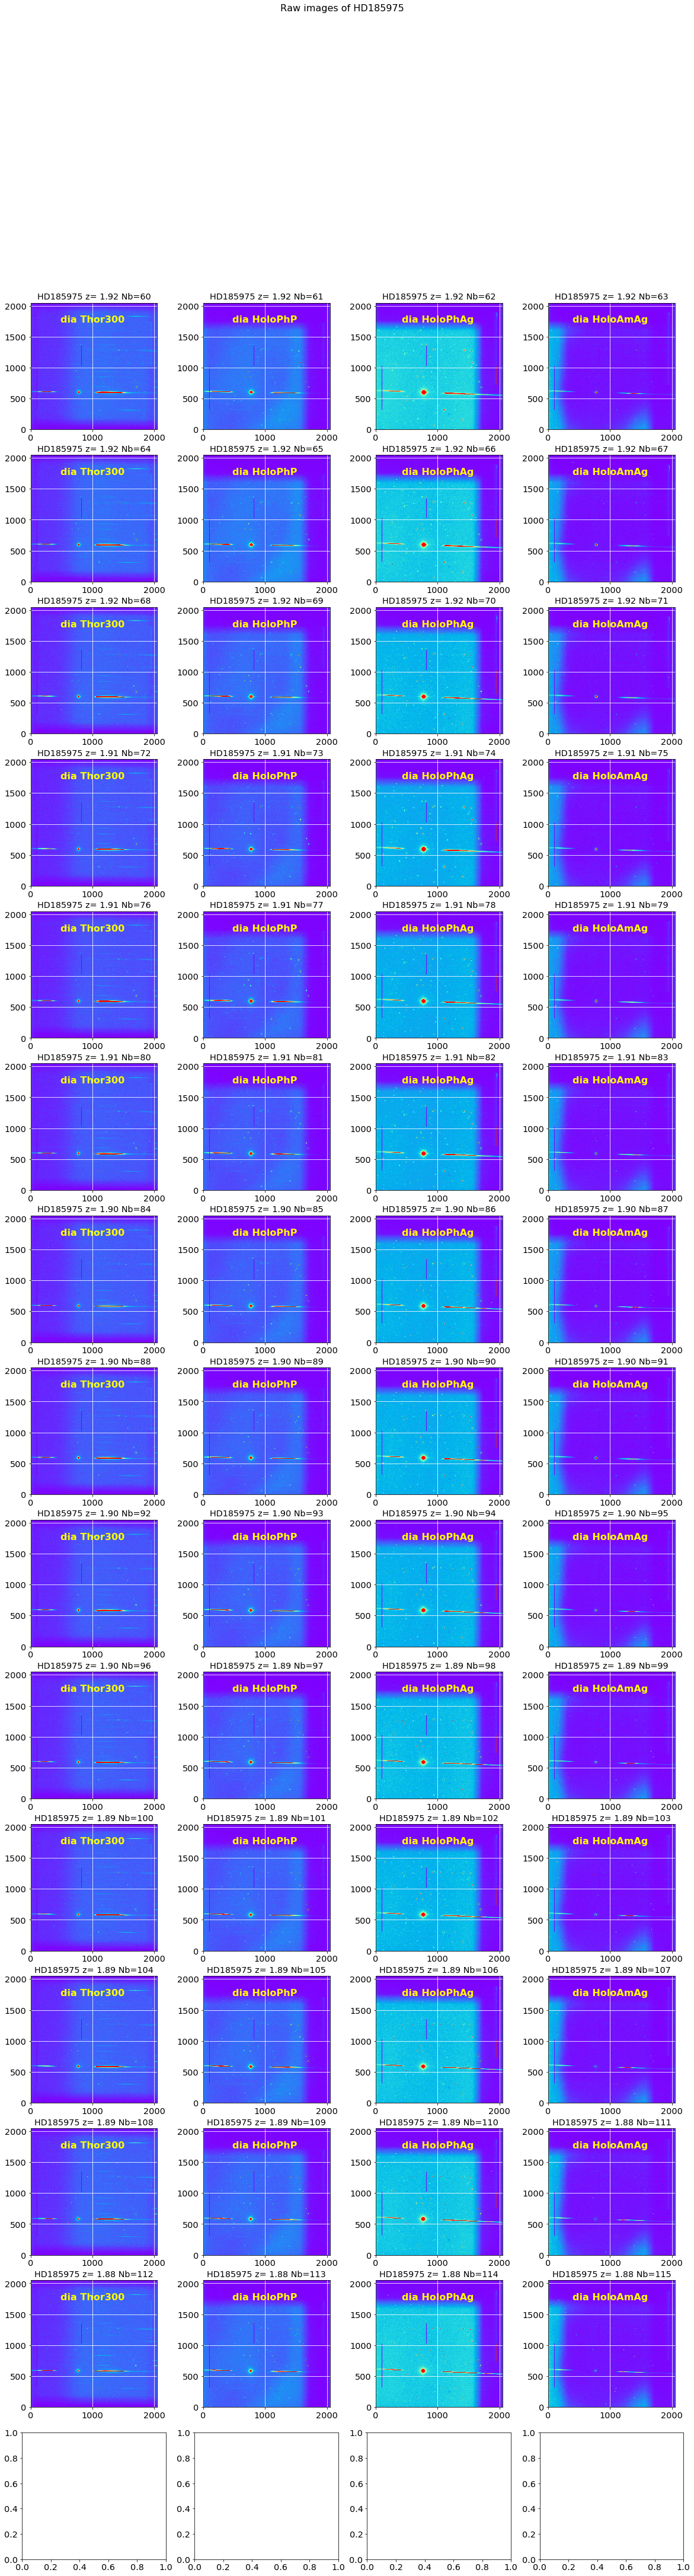

In [117]:
ShowRawImages()

### Find the star locations
----------------------------

In [169]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=6.0, threshold=500*std)
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources

In [170]:
img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

----------------------------------------------------------------
0  mean, median, std =  82.937671332 92.0 34.9812300961


        Use DAOStarFinder instead. [astropy.utils.decorators]


 id   xcentroid     ycentroid   ...   peak       flux          mag      
--- ------------- ------------- ... ------- ------------- --------------
  1 773.345008291 601.470938165 ... 60679.0 2.84477727937 -1.13512067672
----------------------------------------------------------------
1  mean, median, std =  84.0450687154 105.0 55.5654072693
 id   xcentroid     ycentroid   ...   peak      flux          mag      
--- ------------- ------------- ... ------- ------------ --------------
  1 772.688338966 592.518383679 ... 60685.0 2.8520568748 -1.13789545457
----------------------------------------------------------------
2  mean, median, std =  172.379237857 234.0 115.948466205
 id   xcentroid    ycentroid   ...   peak       flux           mag      
--- ------------- ------------ ... ------- ------------- ---------------
  1 773.785749992 615.85503855 ... 60555.0 1.54503114956 -0.472343099284
----------------------------------------------------------------
3  mean, median, std =  38.06277007

In [171]:
sel=1

In [172]:
thesource=img_sources[sel]
img_size=all_images[sel].shape

In [173]:
print thesource

 id   xcentroid     ycentroid   ...   peak      flux          mag      
--- ------------- ------------- ... ------- ------------ --------------
  1 772.688338966 592.518383679 ... 60685.0 2.8520568748 -1.13789545457


In [174]:
x_star=thesource["xcentroid"]
y_star=thesource["ycentroid"]
points_set=np.array(zip(x_star,y_star))

### Default value 

- if no source were found

In [175]:
x0=x_star[0]
y0=y_star[0]

In [189]:
print 'x0,y0=',x0,y0

x0,y0= 773 601


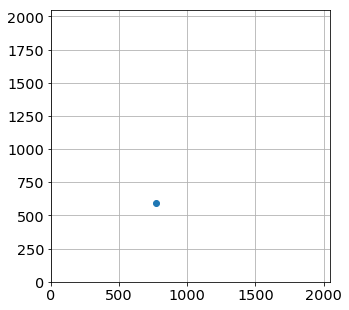

In [176]:
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

### Search the main central star
----------------------------------

In [177]:
%%cython
import numpy as np

"""
Set of routine to find the right position of the main central star
"""
def distance(v1,v2): 
    return sum([(x-y)**2 for (x,y) in zip(v1,v2)])**(0.5)

def GetDistanceSum(thepoint, points_set):
    """
    Return the distance sum of the point thepoit to the set of points points_set
    """
    dist_sum=0
    for otherpoint in points_set:
        dist= distance(thepoint,otherpoint)
        dist_sum+=dist
    return dist_sum

def GetAllDistanceSum(all_points):
    """
    Return the set of the distance sum to other point for all points
    """
    all_distances = []
    for thepoint in all_points:
        dist=GetDistanceSum(thepoint, all_points)
        all_distances.append(dist)
    all_distances=np.array(all_distances)
    return all_distances
        

def GetCentralPosition( x_star, y_star,x0,y0):
    """
    Find the position of the point which minimise the distance sum wrt other points
    """
    
    if x_star.size == 0:
        return np.array([int(y0),int(x0)])
        
    if x_star.size == 1:
        central_pos_index=0
        points_set=np.array(zip(x_star,y_star))
        return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])
    
    points_set=np.array(zip(x_star,y_star))
    distances_sum=GetAllDistanceSum(points_set)
    central_pos_index=np.where(distances_sum==distances_sum.min())[0][0]
    return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])

### Special way to find the right center of the main star

In [178]:
positions_central = []
index=0
for source in img_sources:
    x_star=source["xcentroid"]
    y_star=source["ycentroid"]
    flux=source["flux"]
    position=GetCentralPosition(x_star,y_star,x0,y0)
    print position
    positions_central.append(position)
    index+=1

[601 773]
[592 772]
[615 773]
[598 772]
[599 771]
[591 773]
[615 773]
[592 772]
[598 770]
[589 771]
[592 772]
[592 772]
[595 770]
[588 771]
[579 771]
[592 772]
[593 768]
[592 772]
[592 772]
[592 772]
[593 767]
[585 768]
[573 770]
[591 768]
[593 768]
[582 768]
[592 772]
[590 768]
[591 767]
[581 767]
[592 772]
[592 772]
[591 766]
[581 767]
[592 772]
[588 767]
[589 766]
[580 766]
[592 772]
[587 765]
[588 766]
[597 765]
[562 764]
[586 764]
[588 763]
[578 765]
[592 772]
[585 763]
[585 763]
[585 760]
[592 772]
[583 763]
[584 762]
[573 763]
[592 772]
[583 761]


### Cut the image
------------------

In [179]:
DeltaY=200
DeltaX=600

In [180]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(20,25))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        y0=int(positions_central[index][0])
        x0=int(positions_central[index][1])
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',vmin=0,vmax=1000,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

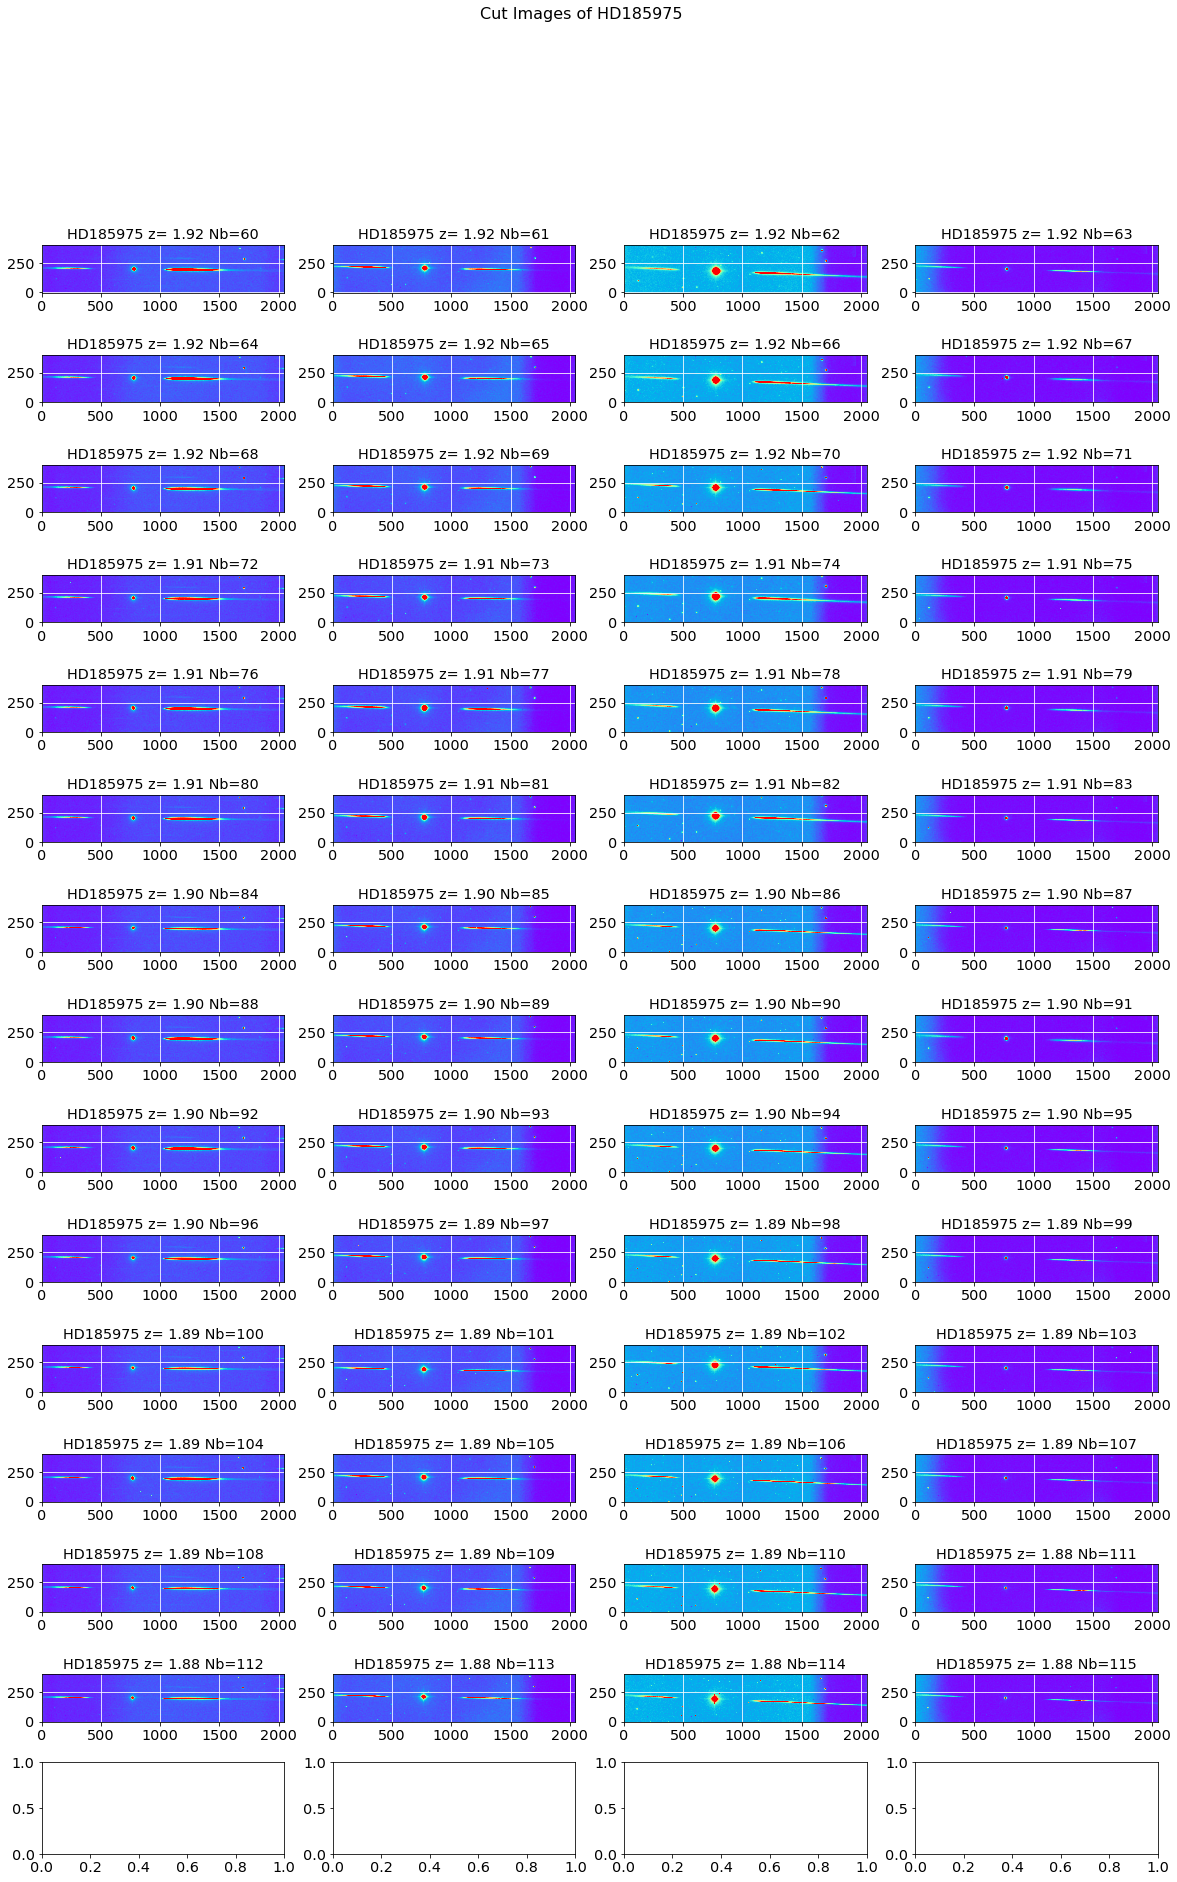

In [181]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images)

#### Example of cut image
-------------------------

In [182]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
data[:,DeltaX-ws:DeltaX+ws]=0

In [183]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [184]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

195


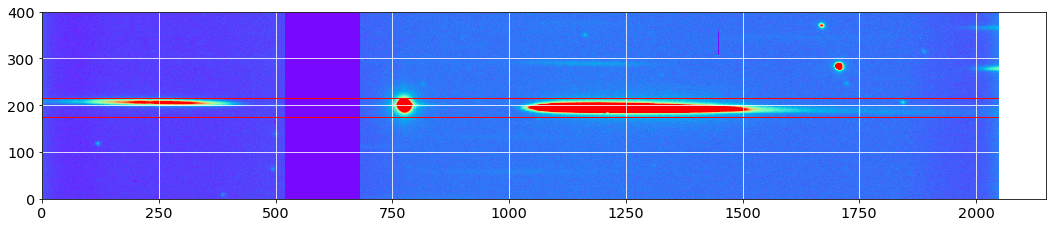

In [190]:
plt.figure(figsize=(18,18))
y0=int(positions_central[index][0])
x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=800,origin='lower',cmap='rainbow',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [186]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

trim_20170528_060.fits
trim_20170528_061.fits
trim_20170528_062.fits
trim_20170528_063.fits
trim_20170528_064.fits
trim_20170528_065.fits
trim_20170528_066.fits
trim_20170528_067.fits
trim_20170528_068.fits
trim_20170528_069.fits
trim_20170528_070.fits
trim_20170528_071.fits
trim_20170528_072.fits
trim_20170528_073.fits
trim_20170528_074.fits
trim_20170528_075.fits
trim_20170528_076.fits
trim_20170528_077.fits
trim_20170528_078.fits
trim_20170528_079.fits
trim_20170528_080.fits
trim_20170528_081.fits
trim_20170528_082.fits
trim_20170528_083.fits
trim_20170528_084.fits
trim_20170528_085.fits
trim_20170528_086.fits
trim_20170528_087.fits
trim_20170528_088.fits
trim_20170528_089.fits
trim_20170528_090.fits
trim_20170528_091.fits
trim_20170528_092.fits
trim_20170528_093.fits
trim_20170528_094.fits
trim_20170528_095.fits
trim_20170528_096.fits
trim_20170528_097.fits
trim_20170528_098.fits
trim_20170528_099.fits
trim_20170528_100.fits
trim_20170528_101.fits
trim_20170528_102.fits
trim_201705

### Save outputfilename

In [187]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

In [188]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_060.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_061.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_062.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_063.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_064.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_065.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_066.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_067.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 23:02 cut_fitsimages/cutimg_20170528_068.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6